#Notebook Overview
This notebook will compare SIREN and biharmonic inpainting (through skitlearn) on a ground truth image (no fence).
The ground truth image was taken from the publicly available dataset and overlaid with a temperature fence mask.
The metrics that will be compared will be:
* Structural Similairty Index
* Peak Signal to noise ratio
* Mean squared error
* Pixel-wise accuracy

#IMPORTS

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [45]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import cv2


import skimage
from skimage import exposure, data, img_as_float
from skimage.restoration import inpaint
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import time

#Creating Artificial Fence Image

##Loading image, cropping it, and displaying thermal values

Image shape: (768, 1024)


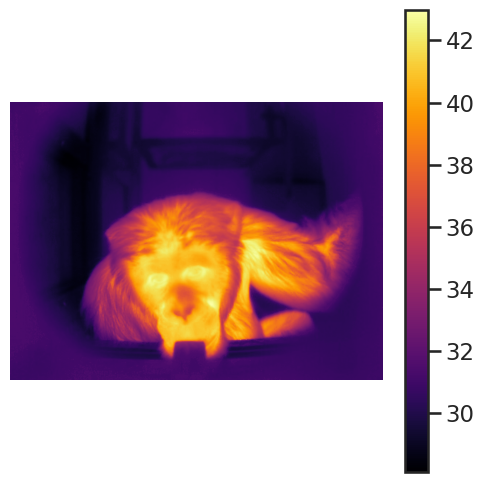

In [46]:
#Loading no fence thermal image and displaying it:
#Image is called No_fence_Primate_image
image_path = "/content/drive/MyDrive/Final Code/no_fence_primate_image.npy"
no_fence_img = np.load(image_path)
print(f"Image shape: {no_fence_img.shape}")

plt.figure(figsize=(6, 6))
plt.imshow(no_fence_img, cmap='inferno')
plt.colorbar()
plt.axis("off")
plt.imsave("Original_image.png", no_fence_img, cmap='inferno')
plt.show()

Min value: 28.10330578512397
Max value: 42.97933884297521


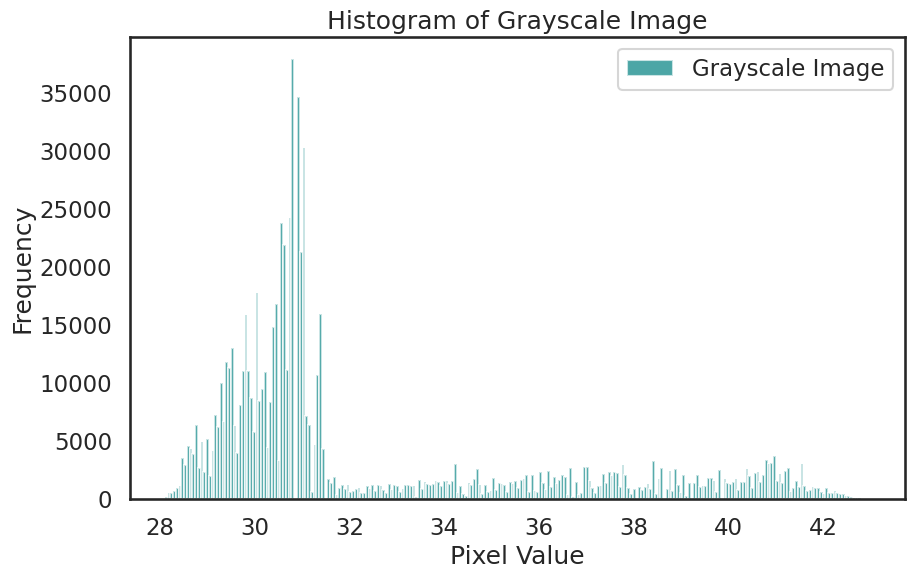

In [47]:
#Data Analysis of image:
#Maximum and minium temperature range for frame
min_value = np.min(no_fence_img)
max_value = np.max(no_fence_img)

print(f"Min value: {min_value}")
print(f"Max value: {max_value}")

#Showing histogram
plt.figure(figsize=(10, 6))
plt.hist(no_fence_img.flatten(), bins=256, color='teal', alpha=0.7, label='Grayscale Image')
plt.title('Histogram of Grayscale Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


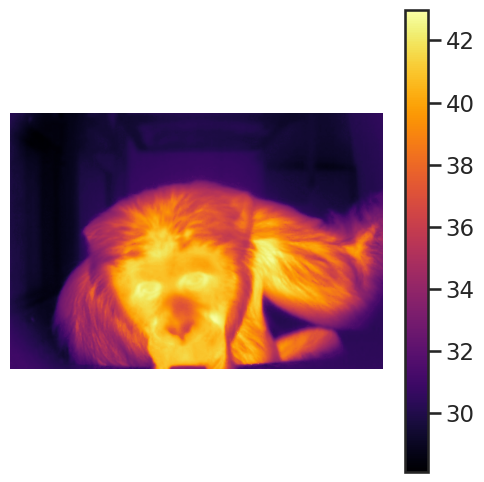

In [48]:
#Cropping it
crop_size = 100
cropped_image = no_fence_img[crop_size:-crop_size, crop_size:-crop_size]

plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap='inferno')
plt.colorbar()
plt.axis("off")
plt.imsave("Cropped_image.png", cropped_image, cmap='inferno')
plt.show()

In [49]:
cropped_image.shape

(568, 824)

##Create mask
Upload a fenced-image, do temperature threshold to create a mask, and put the mask over the non-fenced image. That way we have:
- A) Ground-truth image no fence
- B) Fenced image that we need to inpaint

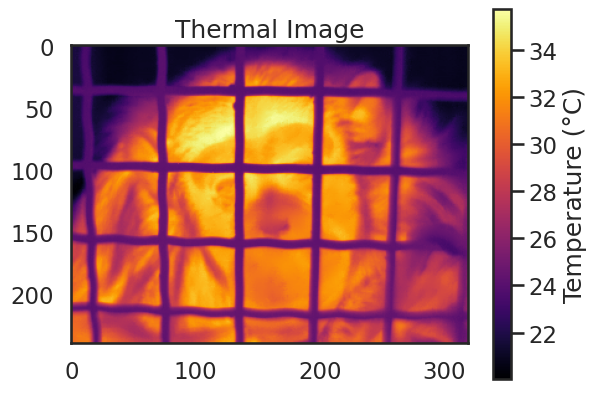

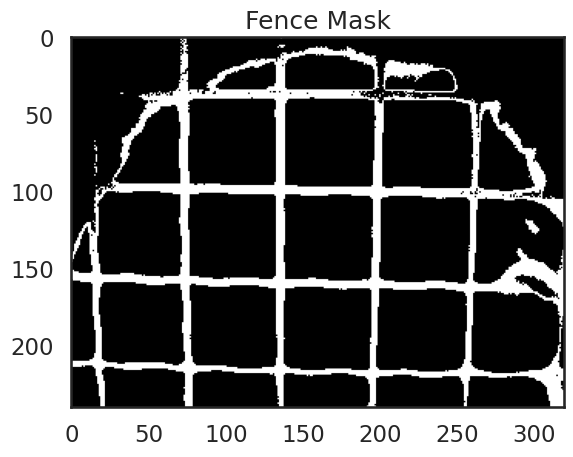

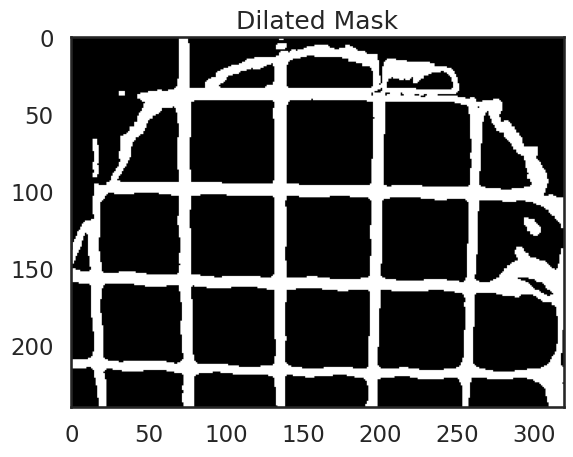

In [50]:
#Loading thermal
thermal_image = np.loadtxt("/content/drive/MyDrive/Final Code/Inpainting_image_to_Test.csv", delimiter=',').reshape((240, 320))

plt.imshow(thermal_image, cmap='inferno')
#plt.imsave("OG_mask_image.png", thermal_image, cmap='gray')
plt.colorbar(label='Temperature (°C)')
plt.title('Thermal Image')
plt.show()

lower_threshold = 24
upper_threshold = 25.30  #28

#Mask
fence_mask = (thermal_image >= lower_threshold) & (thermal_image <= upper_threshold)
fence_mask_norm = fence_mask.astype(np.uint8) * 255

#Dilate mask
kernel = np.ones((3, 3))
dilated_mask = cv2.dilate(fence_mask_norm, kernel, iterations=1)

#Show
plt.imshow(fence_mask_norm, cmap='gray')
plt.title('Fence Mask')
plt.show()
plt.title('Dilated Mask')
plt.imshow(dilated_mask, cmap='gray')
#plt.imsave("Dilated_mask.png", dilated_mask, cmap='gray')
plt.show()


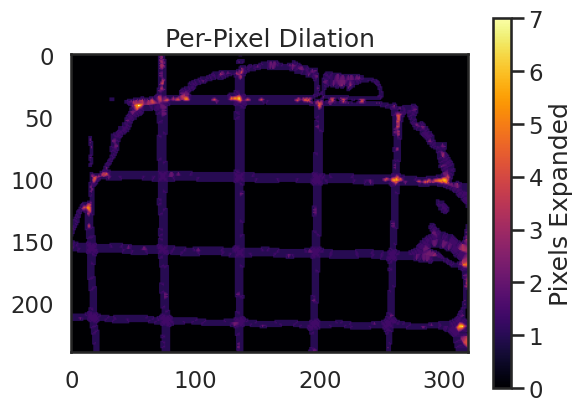

Maximum dilation for any pixel: 7.0


In [51]:
#Distance transforms calculations
#Finding out how much is the maximum pixel dilation
dist_fenced = cv2.distanceTransform(fence_mask_norm, cv2.DIST_L2, 5)
dist_dilated = cv2.distanceTransform(dilated_mask, cv2.DIST_L2, 5)

expansion_per_pixel = dist_dilated - dist_fenced

#Showing area's where pixels expand more than others (pinker ones)
plt.imshow(expansion_per_pixel, cmap='inferno')
plt.colorbar(label='Pixels Expanded')
plt.title('Per-Pixel Dilation')
plt.show()

max_dilation = expansion_per_pixel.max()
print(f"Maximum dilation for any pixel: {max_dilation}")

##Overlaying Fence

Combining the dilated mask (re-sizing it) and thermal image. Resize that combined image. In-painting.

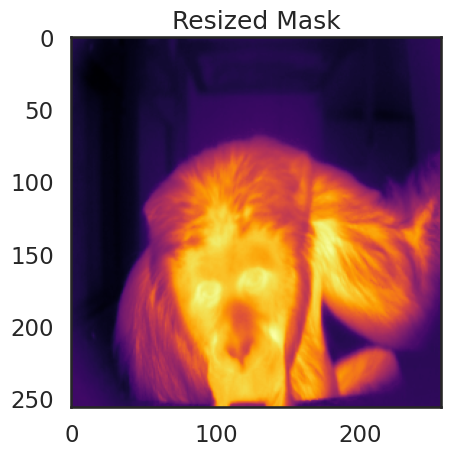

In [52]:
resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)
plt.imshow(resized_image, cmap='inferno')
plt.title('Resized Mask')
#plt.imsave("REsized image.png", resized_image, cmap='inferno')
plt.show()

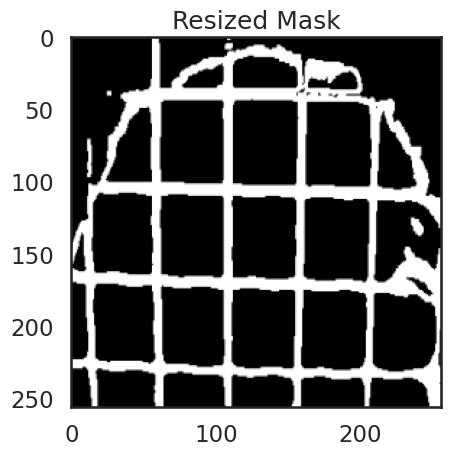

In [53]:
#re-size mask
mask_resized = cv2.resize(dilated_mask.astype(np.uint8), (resized_image.shape[1], resized_image.shape[0]), interpolation=cv2.INTER_AREA)
plt.imshow(mask_resized, cmap='gray')
plt.title('Resized Mask')
#plt.imsave("REsized mask.png", mask_resized, cmap='gray')
plt.show()

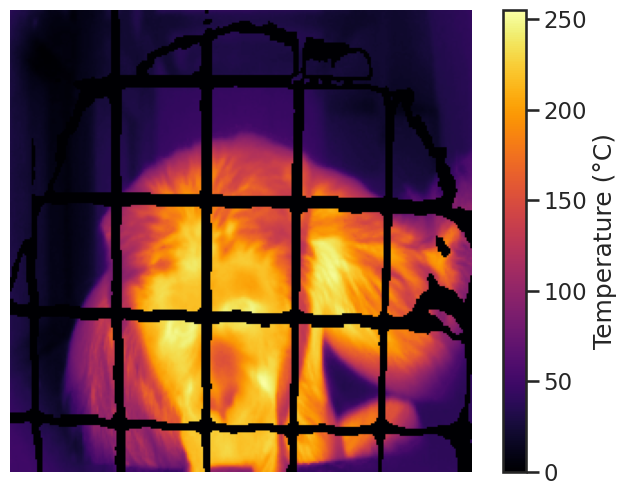

In [54]:
#Both the fence mask and non-fenced thermal image are in temp. range
#need to normalise them to 0-255 range

normalized_thermal_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
combined_image = np.copy(normalized_thermal_image)
combined_image[mask_resized == 255] = 0

#Show fence mask combined with image
plt.figure(figsize=(8, 6))
plt.imshow(combined_image, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.axis('off')  # Hide axes for a cleaner view
#plt.imsave("Inpaint_artifical_combined_resized.pdf", combined_image, cmap='inferno')
plt.show()

#Biharmonic Inpainting

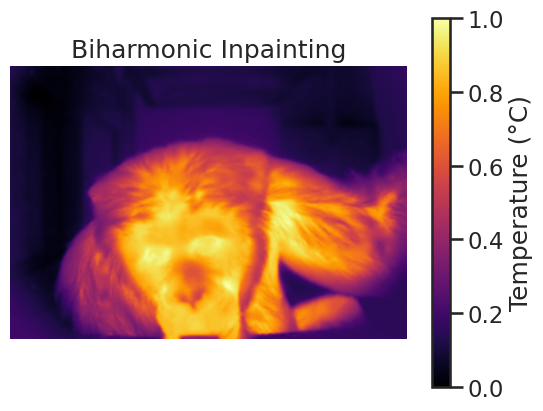

In [55]:
inpainted_image = inpaint.inpaint_biharmonic(combined_image, mask_resized == 255)

#after inpainting convert image to original size to visually see
inpainted_resized = cv2.resize(inpainted_image, (824, 568), interpolation=cv2.INTER_CUBIC)

plt.imshow(inpainted_resized, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Biharmonic Inpainting')
#plt.imsave("Biharmonic_inpaint_artifical.pdf", inpainted_resized, cmap='inferno')
plt.axis('off')
plt.savefig("Biharmonic_inpaint_artifical.pdf", dpi=600, bbox_inches='tight')
plt.show()

##Testing Biharmonic Inpainting with different Metrics

In [56]:
#Testing to make sure that image was inpainted
if np.array_equal(inpainted_image, resized_image):
    print("The images are the same.")
else:
    print("The images are different.")

The images are different.


In [57]:
#Inpainted image is already normalised from 0 to 1
#But the ground-truth image needs to be normalised
inpainted_image

array([[0.14509804, 0.1372549 , 0.13333333, ..., 0.16078431, 0.16470588,
        0.16470588],
       [0.14117647, 0.13333333, 0.12941176, ..., 0.16078431, 0.16470588,
        0.16470588],
       [0.1372549 , 0.13333333, 0.12941176, ..., 0.15686275, 0.16470588,
        0.16470588],
       ...,
       [0.19215686, 0.19215686, 0.19215686, ..., 0.15332311, 0.15311618,
        0.15301313],
       [0.19215686, 0.19215686, 0.19215686, ..., 0.15378534, 0.1534694 ,
        0.15331637],
       [0.19215686, 0.19215686, 0.18823529, ..., 0.15405585, 0.15367417,
        0.15349082]])

In [58]:
def normalize_imagess(image, min_val, max_val):
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * (max_val - min_val) + min_val

ground_truth = normalize_imagess(resized_image, 0, 1)

###Structural Similarity Index Measure
Evaluates structural similarity (e.g., textures, edges). S(x, y) = F(l(x, y),c(x, y),s(x, y)).

In [59]:
ssim_inpaint_1 = ssim(ground_truth, inpainted_image, data_range=1.0) # range is 0-1
print(ssim_inpaint_1)

0.9871056171225165


###PSNR:
Peak signal-to-noise ratio.
Measures pixel-wise fidelity: comparing the maximum power of a signal to the power of corrupting noise.

In [60]:
#PSNR:
def calculate_psnr(ground_truth, inpainted_image):
    mse = np.mean((ground_truth - inpainted_image) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

In [61]:
psnr_value = calculate_psnr(ground_truth, inpainted_image)
print(psnr_value)

41.711506844685516


###Pixel-wise Accuracy

In [62]:
#Re-normalise it to thermal values
#That way for pixel accuracy we can compare to what temperature degree they are different
#For other metrics do not need temperature normalisation (works 0-1 range)
#We have converted raw temperature values to 0-255, then biharmonic converts it to 0-1
#Now we re-normalise it back to raw temperautre values
#with min:28.10330578512397
#with max: 42.97933884297521
inpainted_thermal = inpainted_image * (42.98 - 28.10) + 28.10

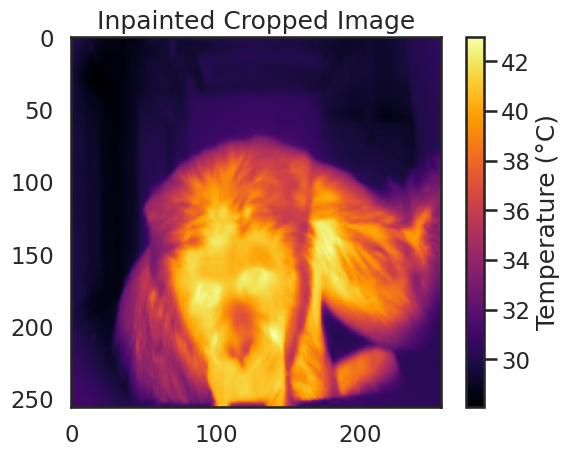

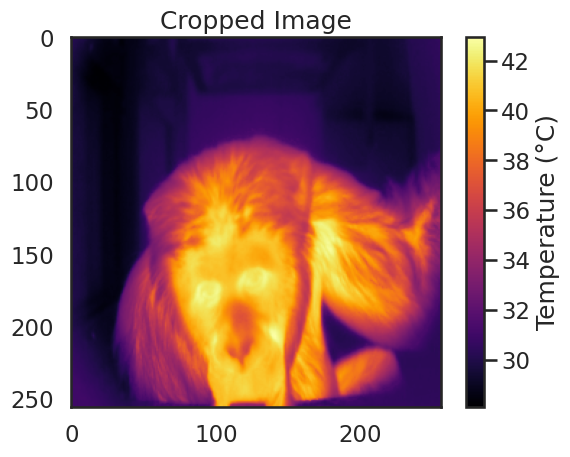

In [63]:
plt.imshow(inpainted_thermal, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Cropped Image')
plt.show()

plt.imshow(resized_image, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Cropped Image')
plt.show()

In [64]:
#Mean squared error: #Measures the average squared error between the images.
mse = mean_squared_error(inpainted_thermal, resized_image)
print(mse)

0.01496416452813594


In [ ]:
#Just pixel-wise accuracy for masked area's

In [65]:
mask_binary = (mask_resized == 255).astype(np.uint8)

In [66]:
#np.sum(mask_binary == 1) ->gives the mask that is equal to 1: 13684 pixels
#np.sum(mask_binary == 0) ->gives you unfenced part of mask/ 0: 51852 pixels (The remaining)
#ground_truth_pixels is a list of all the values of the mask
#Hence it's size is the same as the mask: len(ground_truth_pixels) ->13684
ground_truth_pixels = resized_image[mask_binary == 1]

#Repeat but for inpainted image:
inpainted_image_pixels = inpainted_thermal[mask_binary == 1]

#just calculate how many got correct overall considering numbers at 2 decimal places:

matching_pixels = np.isclose(ground_truth_pixels, inpainted_image_pixels, atol= 0.4)
#allowing only a 0.4°C degree's of difference
#e.g. 0.01 ->Matches values like 0.1234 and 0.1225 because their absolute difference (0.0009) is within tolerance.

# It means that two pixel values are considered "close enough" (and therefore a match) if their absolute difference is less than or equal to 0.01.
#Ground truth pixel: 0.753
#Inpainted pixel: 0.762
#The absolute difference between them is |0.753 - 0.762| = 0.009.

#Since 0.009 is less than 0.01 (your atol), np.isclose() would return True for this pixel pair, indicating a match.

#VS method below that first rounds everythign to 2 decimal places and then compares accuracy

# Compute accuracy as the percentage of matching pixels
pixel_accuracy = np.sum(matching_pixels) / len(ground_truth_pixels)

print(f"{pixel_accuracy * 100:.2f}%")




90.97%


In [67]:
#Rounding temperature values to the nearest degree
#e.g. 29.5 vs 29.6 (0.1 degree of difference)
# Compare pixel values by rounding to two decimal places
matching_pixels = np.round(ground_truth_pixels, 1) == np.round(inpainted_image_pixels, 1)

# Compute accuracy as the percentage of matching pixels
pixel_accuracy = np.sum(matching_pixels) / len(ground_truth_pixels)

print(f"Pixel Accuracy in Masked Regions (up to 2 decimal places): {pixel_accuracy * 100:.2f}%")

Pixel Accuracy in Masked Regions (up to 2 decimal places): 36.72%


In [68]:
#rounding temperature values (so you just have degree's no points)
# Compare pixel values by rounding to two decimal places
matching_pixels = np.round(ground_truth_pixels) == np.round(inpainted_image_pixels)

# Compute accuracy as the percentage of matching pixels
pixel_accuracy = np.sum(matching_pixels) / len(ground_truth_pixels)

print(f"Pixel Accuracy in Masked Regions (up to 2 decimal places): {pixel_accuracy * 100:.2f}%")

Pixel Accuracy in Masked Regions (up to 2 decimal places): 86.34%


#SIREN training for Inpainting

##Network Set up

In [69]:
#################Code only in this cell was directly copied from SIREN papper ##################
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

##Pre-processing the Image

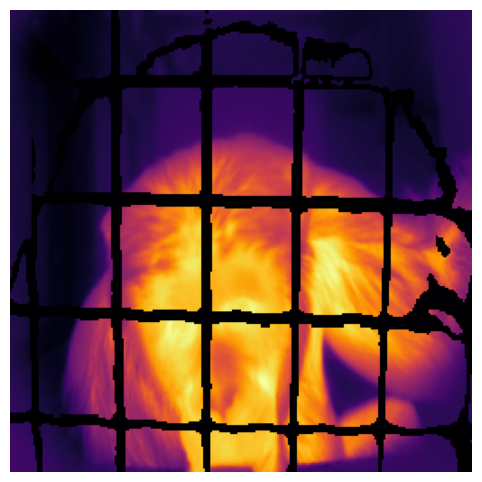

In [70]:
#Displaying our earlier combined artifical fenced image
plt.figure(figsize=(8, 6))
plt.imshow(combined_image, cmap='inferno')
plt.axis('off')
plt.show()

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)
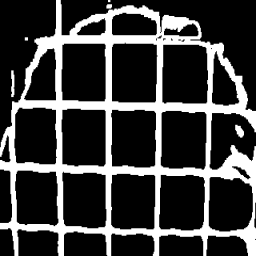

In [71]:
mask_resized

In [72]:
non_fence_mask = (mask_resized == 0).astype(np.float32) #Makes 0 the fence area and 1 the non-fence area
non_fence_mask.shape

(256, 256)

In [73]:
def preprocess_combined_image(thermal_data):
    #Normalize to range [0, 1]
    thermal_data = (thermal_data - np.min(thermal_data)) / (np.max(thermal_data) - np.min(thermal_data))

    # Convert to PIL Image for compatibility with torchvision transforms
    thermal_image = Image.fromarray(thermal_data)

    #Define and apply transformations
    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(thermal_image)
    return img

class ThermalImageDataset(Dataset):
    def __init__(self, csv_file_path, sidelength):
        super().__init__()
        img = preprocess_combined_image(csv_file_path)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)  # Flatten to (num_pixels, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        return self.coords, self.pixels

#Load in the combined image and pre-process it into thermal dataset
sidelength = 256
thermal_dataset = ThermalImageDataset(combined_image, sidelength)
dataloader = DataLoader(thermal_dataset, batch_size=1, pin_memory=True, num_workers=0)


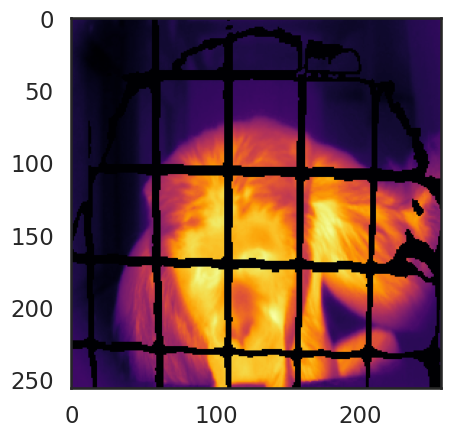

In [74]:
#Testing image
#doing permutation: height, width, channels to see
img = preprocess_combined_image(combined_image)
plt.imshow(img.permute(1, 2, 0), cmap = "inferno")
plt.show()

In [75]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

##Training SIREN

In [22]:
total_steps = 1000 #total epochs
steps_til_summary = 10 #print summary every 10 epochs

#adam optimsier with 0.0001 learning rate
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

# Move model and data to GPU
img_siren.cuda()
coordin_grid, pixel_value = next(iter(dataloader))
coordin_grid, pixel_value = coordin_grid.cuda(), pixel_value.cuda()

for step in range(total_steps):
    model_output_pixel, coords = img_siren(coordin_grid)
    model_output_reshaped = model_output_pixel.view(sidelength, sidelength) #making the pixel values into 256 x 256 grid

    #making sure the non_fence_mask is proper size (256 x 256)
    non_fence_mask_resize = cv2.resize(non_fence_mask, (sidelength, sidelength), interpolation=cv2.INTER_NEAREST)
    non_fence_mask_tensor = torch.tensor(non_fence_mask_resize, dtype=torch.float32).cuda()

    #model’s output is masked so that only predictions for non-fenced regions are considered
    no_Fence_output_model = model_output_reshaped * non_fence_mask_tensor
    #Only the non-fenced area pixel values
    non_fenced_pixels_groundtruth = ground_truth.view(sidelength, sidelength) * non_fence_mask_tensor
    loss = ((no_Fence_output_model - non_fenced_pixels_groundtruth) ** 2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output_pixel, coords)
        img_laplacian = laplace(model_output_pixel, coords)

        #Using CPU for visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(model_output_pixel.cpu().view(256, 256).detach().numpy(), cmap="gray")
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256, 256).detach().numpy(), cmap="gray")
        axes[2].imshow(img_laplacian.cpu().view(256, 256).detach().numpy(), cmap="gray")
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

##Saving Image and Testing SIREN Performance
We now save the inpainted image then run tests on it.

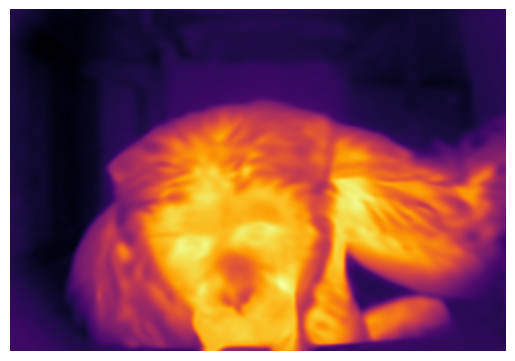

In [26]:
#Get the final epoch image
final_output = model_output_pixel.view(sidelength, sidelength)
#normalising and scaling (0-255)
tensor = final_output - final_output.min()
tensor = tensor / tensor.max()
img_siren = (tensor.cpu().detach().numpy() * 255).astype(np.uint8)

#Re-size up
inpainted_resized = cv2.resize(img_siren, (824, 568), interpolation=cv2.INTER_CUBIC)
plt.axis('off')
plt.imshow(inpainted_resized, cmap="inferno")
plt.savefig("SIREN inpaint Artificial.pdf", dpi=600, bbox_inches='tight')
plt.show()

##Testing

In [27]:
#Testing to make sure that image was inpainted
if np.array_equal(img_siren, resized_image):
    print("The images are the same.")
else:
    print("The images are different.")

The images are different.


In [28]:
#We have to normalise both the inpainted image (0-255) and the ground-truth image (0-255 but float number) and should be 0 to 1 fo these tests
def normalize_imagess(image, min_val, max_val):
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * (max_val - min_val) + min_val

ground_truth = normalize_imagess(resized_image, 0, 1)
inpainted_image = normalize_imagess(img_siren, 0, 1)

In [29]:
#Structural Similarity Index Measure
ssim_inpaint_1 = ssim(ground_truth, inpainted_image, data_range=1.0)
print(ssim_inpaint_1)

0.9610209240270278


In [32]:
#Peak signal-to-noise ratio.
psnr_value = calculate_psnr(ground_truth, inpainted_image)
print(psnr_value)

36.17191710680475


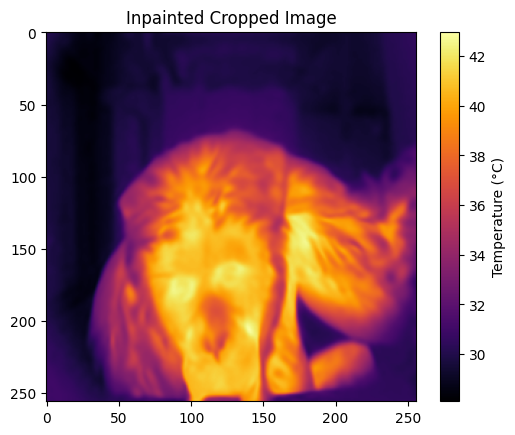

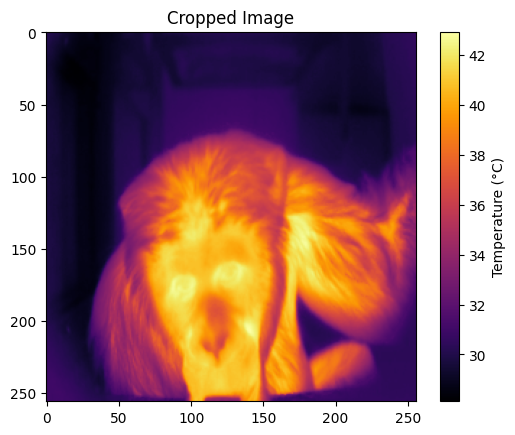

In [33]:
#Pixel-wise:
#resized_image is already in temperature values, but we need to un-normalise inpainted image to get temperature values
inpainted_thermal = inpainted_image * (42.98 - 28.10) + 28.10
plt.imshow(inpainted_thermal, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Cropped Image')
plt.show()

plt.imshow(resized_image, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.title('Cropped Image')
plt.show()

In [34]:
mse = mean_squared_error(inpainted_thermal, resized_image)
print(mse)

0.05271689060844509


In [36]:
ground_truth_pixels = resized_image[mask_binary == 1]

#Repeat but for inpainted image:
inpainted_image_pixels = inpainted_thermal[mask_binary == 1]

#just calculate how many got correct overall considering numbers at 2 decimal places:

matching_pixels = np.isclose(ground_truth_pixels, inpainted_image_pixels, atol= 0.4)
#allowing only a 0.4°C degree's of difference
#e.g. 0.01 ->Matches values like 0.1234 and 0.1225 because their absolute difference (0.0009) is within tolerance.

# It means that two pixel values are considered "close enough" (and therefore a match) if their absolute difference is less than or equal to 0.01.
#Ground truth pixel: 0.753
#Inpainted pixel: 0.762
#The absolute difference between them is |0.753 - 0.762| = 0.009.

#Since 0.009 is less than 0.01 (your atol), np.isclose() would return True for this pixel pair, indicating a match.

#VS method below that first rounds everythign to 2 decimal places and then compares accuracy

# Compute accuracy as the percentage of matching pixels
pixel_accuracy = np.sum(matching_pixels) / len(ground_truth_pixels)

print(f"{pixel_accuracy * 100:.2f}%")


79.38%


In [37]:
matching_pixels = np.round(ground_truth_pixels, 1) == np.round(inpainted_image_pixels, 1)

# Compute accuracy as the percentage of matching pixels
pixel_accuracy = np.sum(matching_pixels) / len(ground_truth_pixels)

print(f"Pixel Accuracy in Masked Regions (up to 2 decimal places): {pixel_accuracy * 100:.2f}%")

Pixel Accuracy in Masked Regions (up to 2 decimal places): 22.33%


In [38]:
matching_pixels = np.round(ground_truth_pixels) == np.round(inpainted_image_pixels)

# Compute accuracy as the percentage of matching pixels
pixel_accuracy = np.sum(matching_pixels) / len(ground_truth_pixels)

print(f"Pixel Accuracy in Masked Regions (up to 2 decimal places): {pixel_accuracy * 100:.2f}%")

Pixel Accuracy in Masked Regions (up to 2 decimal places): 75.77%


#Plotting

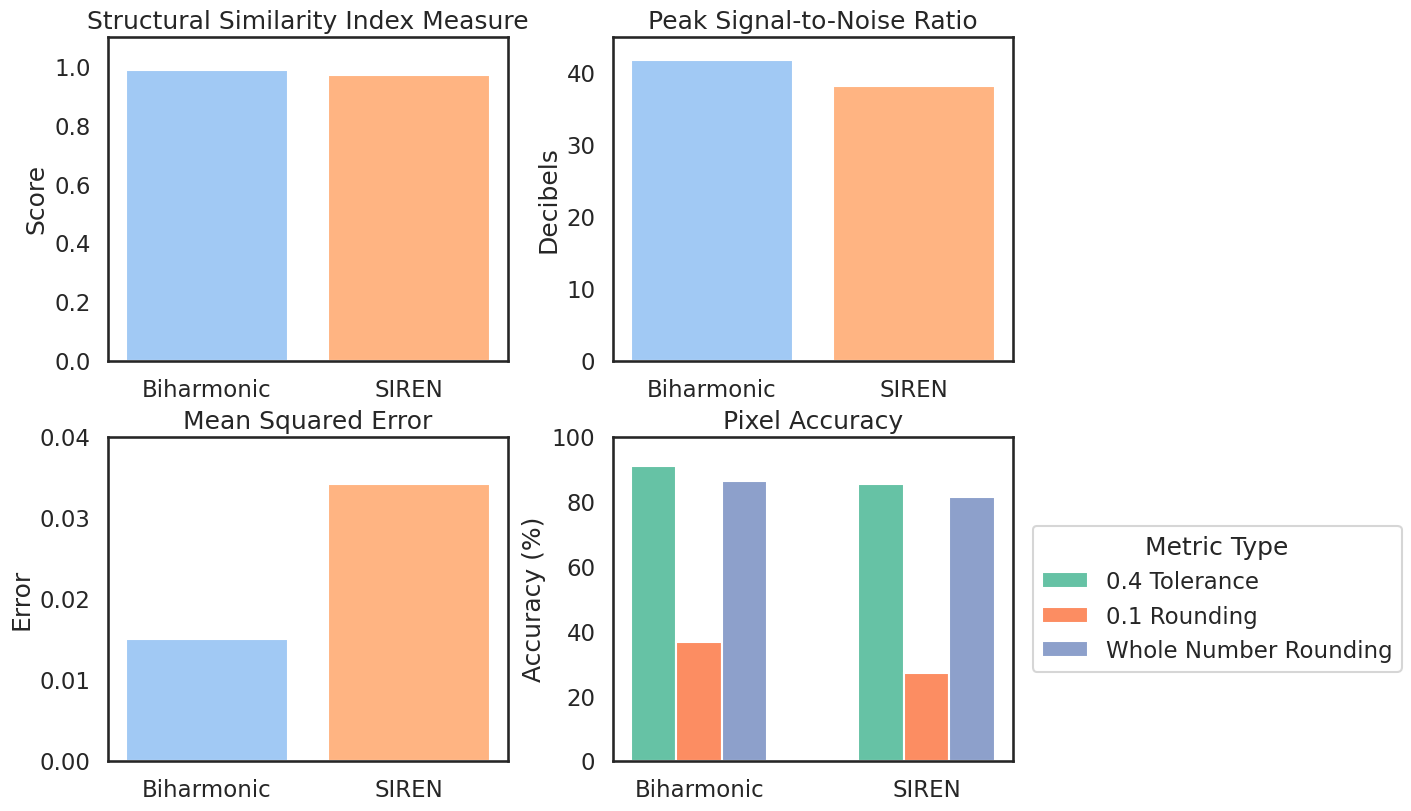

In [39]:
#NOTE:
#Slightly different values for SIREN each time you run the cell above is because there was no fixed seed
#And so results change slightly each time they are run
sns.set(style="white", context="talk")

methods = ['Biharmonic', 'SIREN']
ssim = [0.98710, 0.97043]
psnr = [41.711, 38.10509]
mse = [0.014964, 0.03412]
pixel_accuracy = {
    '0.4 Tolerance': [90.97, 85.27],
    '0.1 Rounding': [36.72, 27.13],
    'Whole Number Rounding': [86.34, 81.31]
}

#Using color sets
ssim_colors = sns.color_palette("pastel")[:2]
psnr_colors = sns.color_palette("pastel")[:2]
mse_colors = sns.color_palette("pastel")[:2]
accuracy_colors = sns.color_palette("Set2")

fig, axs = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
axs = axs.flatten()

#No gridlines
for ax in axs:
    ax.grid(False)

#SSIM
axs[0].bar(methods, ssim, color=ssim_colors)
axs[0].set_title("Structural Similarity Index Measure")
axs[0].set_ylabel("Score")
axs[0].set_ylim(0, 1.1)

#PSNR
axs[1].bar(methods, psnr, color=psnr_colors)
axs[1].set_title("Peak Signal-to-Noise Ratio")
axs[1].set_ylabel("Decibels")
axs[1].set_ylim(0, 45)

#MSE
axs[2].bar(methods, mse, color=mse_colors)
axs[2].set_title("Mean Squared Error")
axs[2].set_ylabel("Error")
axs[2].set_ylim(0, 0.04)

#Pixel Accuracy (grouped bars)
x = np.arange(len(methods))
width = 0.2
offsets = [-width, 0, width]

for i, (label, values) in enumerate(pixel_accuracy.items()):
    axs[3].bar(x + offsets[i], values, width, label=label, color=accuracy_colors[i])

axs[3].set_title("Pixel Accuracy")
axs[3].set_ylabel("Accuracy (%)")
axs[3].set_xticks(x)
axs[3].set_xticklabels(methods)
axs[3].set_ylim(0, 100)

#Legend for last chart
axs[3].legend(
    title="Metric Type",
    frameon=True,
    fancybox=True,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.5
)

plt.savefig("Inpainting_compared_best_2.png", dpi=600, bbox_inches='tight')
plt.show()
